In [ ]:
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt
import seaborn as sns
import altair as alt
import os

from scipy import stats

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.cluster import KMeans

In [ ]:
def unique_summary(df, categorical_threshold=98, rows=None):
    # values_to_98 = (-(98 / 100) + 1 ) * 12330
    #values_to_98
    # Perc_unique measures, approximately, how close the feature is to a categorical type.
    if rows == None:
        rows = df.shape[0]
    perc_unique = (100 * (1 - (df.nunique() / rows)))
    unique_summary = pd.concat((df.nunique().rename("Number_unique"),
                                perc_unique.rename("Perc_unique"),
                                (perc_unique >= categorical_threshold).rename("Is categorical")
                               ), axis=1)
    return unique_summary.sort_values("Number_unique")

def null_summary(df, rows=None):
    if rows == None:
        rows = df.shape[0]
    result = pd.concat((df.isnull().sum().rename("Number null"),
                        (100 * df.isnull().sum() / rows).rename("Perc null")),
                       axis=1)
    return result

def impute_nulls(df, columns=None, method="mode"):
    if isinstance(columns, type(None)):
        columns = df.columns
    if method == "mode":
        imputation_values = df[columns].mode().to_dict("records")[0]
    temp = df.copy()
    temp.loc[:, columns] = temp[columns].fillna(imputation_values).copy() # .isnull().sum()
    return temp

def category_frequencies(serie):
    temp = serie.value_counts()
    name = temp.name
    # Compute absolute, relative frequencies and its cumulative summation
    temp = pd.concat((temp.rename("F_abs"),
                      100 * temp.div(temp.sum()).rename("F_rel")),
                     axis=1)
    temp["F_rel_cum"] = temp["F_rel"].cumsum()
    temp.sort_values("F_rel", inplace=True)
    temp.index.rename(name, inplace=True)
    return temp

def category_frequencies_target(df, column, target):
    temp = df.value_counts([column, target])
    name = temp.name
    # Compute absolute, relative frequencies and its cumulative summation
    temp = pd.concat((temp.rename("F_abs"),
                      100 * temp.div(temp.sum()).rename("F_rel")),
                     axis=1)
    temp["F_rel_cum"] = temp["F_rel"].cumsum()
    temp.sort_values("F_rel", inplace=True)
    #temp.index.rename(name, inplace=True)
    return temp

def pair_grouping(df, return_col_groups=False, return_only_relative=False):
    all_dataframes = []
    ignore_col = []
    used_cols = []
    cat_columns = df.columns
    for main_col in cat_columns:
        ignore_col.append(main_col)
        for columna in cat_columns:
            if columna in ignore_col:
                continue
            if return_col_groups:
                used_cols.append((main_col, columna))
            df_grouped = df.groupby([main_col, columna]).size().to_frame("F_abs")
            total_nonull = df_grouped.sum()
            df_grouped.sort_values("F_abs", inplace=True)

            df_grouped['F_rel (%)'] = df_grouped.mul(100 / total_nonull)
            df_grouped.sort_values('F_rel (%)', ascending=False, inplace=True)
            df_grouped['F_rel_cum'] = df_grouped['F_rel (%)'].cumsum()
            df_grouped.sort_values('F_rel (%)', ascending=False, inplace=True)
            #df_grouped.reset_index(inplace=True)
            if return_only_relative:
                df_grouped = df_grouped['F_rel (%)']
            all_dataframes.append(df_grouped)

    if return_col_groups:
        return all_dataframes, used_cols
    return all_dataframes

def extract_relevant_pairs(group_list, number_pairs=10):
    relevant_pairs = []
    """ for group in group_list:
        group = group.head(number_pairs)"""
    while group_list:
        relevant_pairs.append(group_list.pop().head(number_pairs))
    return relevant_pairs

def bar_plot_groups(df, columns, target, figsize=(14, 24), axes_fc="lightgray", fig_fc="gray"):
    fig, axes = plt.subplots(len(columns), 1, figsize=figsize)
    fig.set_facecolor(fig_fc)

    for ax, column in zip(axes, columns):
        if column != target:
            group = category_frequencies_target(df, column, target).reset_index()
            sns.barplot(data=group,
                        y="F_rel",
                        x=column,
                        hue=target,
                        ax=ax
                       )
            ax.set_facecolor(axes_fc)
    plt.tight_layout()
    return axes

def bar_plot_group_list(groups, figsize=(20, 60), axes_fc="lightgray", fig_fc="gray"):
    fig, axes = plt.subplots(len(groups) // 2, 2, figsize=figsize)
    axes = axes.ravel()
    fig.set_facecolor(fig_fc)

    for ax, group in zip(axes, groups):
        temp = group.copy()
        temp.reset_index(inplace=True)
        temp['aux'] = temp.iloc[:, :2].astype(str).agg('-'.join, axis=1)
        sns.barplot(data=temp,
                    y="F_rel (%)",
                    x='aux',
                    #hue=target,
                    ax=ax,
                    palette= sns.color_palette("crest") #rocket
                   )
        ax.annotate(str(round(temp["F_rel_cum"].iloc[-1], 2)), xy=(5, 5))
        ax.set_facecolor(axes_fc)
    plt.tight_layout()
    #return axes
    return None

def extended_describe(dataframe):
    # coefficient of variation
    simple_stats = dataframe.describe().drop(["count"]).T
    simple_stats["cv"] = simple_stats["std"].div(simple_stats["mean"])
    # unbiased estimator coefficient of variation
    simple_stats["unbiased_cv"] = (1 + (1 / (4 * rows))) * simple_stats["std"]
    # quartile coefficient of dispersion
    simple_stats["qcd"] = (simple_stats["75%"] - simple_stats["25%"]) / \
        (simple_stats["75%"] + simple_stats["25%"])
    # MAD
    simple_stats["MAD"] = dataframe.mad()
    # IQR
    simple_stats["IQR"] = simple_stats["75%"] - simple_stats["25%"]

    return simple_stats.T

def extended_describe_serie(serie):
    # coefficient of variation
    simple_stats = serie.describe().drop(["count"]).T
    simple_stats["cv"] = simple_stats["std"] / simple_stats["mean"]
    # unbiased estimator coefficient of variation
    simple_stats["unbiased_cv"] = (1 + (1 / (4 * rows))) * simple_stats["std"]
    # quartile coefficient of dispersion
    simple_stats["qcd"] = (simple_stats["75%"] - simple_stats["25%"]) / \
        (simple_stats["75%"] + simple_stats["25%"])
    # MAD
    simple_stats["MAD"] = serie.mad()
    # IQR
    simple_stats["IQR"] = simple_stats["75%"] - simple_stats["25%"]

    return simple_stats.T

def multi_boxplot_hist(df, target, bins=None, axes_fc="lightgray", fig_fc="gray"):
    temp = df
    number_rows, number_columns = temp.shape
    fig, axes = plt.subplots(number_columns - 1, 2, figsize=(14, 24))
    # (20, 12 + (number_columns - 1) * 2)
    fig.set_facecolor(fig_fc)
    if bins == None:
        bins = int(np.sqrt(number_rows))

    temp[target].cat.as_ordered(inplace=True)
    for column, ax in zip(temp.columns, axes):
        if column != target:
            sns.boxplot(data=temp, x=column,  y=target, ax=ax[0], orient="h")
            ax[0].set_facecolor(axes_fc)
            sns.histplot(data=temp[temp[target] == True], x=column, ax=ax[1], bins=bins)
            ax[1].set_facecolor(axes_fc)
            #sns.violinplot(data=temp, y=column, inner="points", ax=ax[2], alpha=0.6) # , palette="light:g"
    plt.tight_layout()

def multi_plot_numerical(df, target, which_plot="boxplot", bins=None, stat="probability", axes_fc="lightgray", fig_fc="gray"):
    temp = df
    number_rows, number_columns = temp.shape
    if which_plot == "hist":
        fig, axes = plt.subplots(number_columns - 1, 2, figsize=(16, 24))
    else:
        fig, axes = plt.subplots(number_columns - 1, 1, figsize=(16, 24))
    fig.set_facecolor(fig_fc)
    if which_plot == "hist":
        if bins == None:
            bins = int(np.sqrt(number_rows))

    temp[target].cat.as_ordered(inplace=True)
    for column, ax in zip(temp.columns, axes):
        if column != target:
            if which_plot == "hist":
                sns.histplot(data=temp[temp[target] == 0], x=column, hue=target, ax=ax[0], bins=bins, stat=stat) # temp[temp[target] == True]
                ax[0].set_facecolor(axes_fc)
                ax[0].set_title("Class zero")
                sns.histplot(data=temp[temp[target] == 1], x=column, hue=target, ax=ax[1], bins=bins, stat=stat) # temp[temp[target] == True]
                ax[1].set_facecolor(axes_fc)
                ax[1].set_title("Class one")
            else:
                sns.boxplot(data=temp, x=column,  y=target, ax=ax, orient="h")
                sns.stripplot(data=temp, x=column,  y=target, ax=ax, orient="h", color="red",
                              alpha=0.2,
                              size=1
                             )
                ax.set_facecolor(axes_fc)
    plt.tight_layout()

def detect_outliers_IQR_serie(serie, IQR_prop=1.5):
    # test function: pass a serie
    stats = extended_describe_serie(serie)
    Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"]]
    # returns data points which are NOT between the range
    return ~serie.between(Q1 - IQR_prop * IQR, Q3 + IQR_prop * IQR)

def detect_outliers_IQR_df(df, IQR_prop=1.5):
    # test function: pass a dataframe
    stats = extended_describe(df)
    temp = df.copy()
    for col in temp.columns:
        Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"], col]
        # returns data points which are NOT between the range
        temp[col] = ~temp[col].between(Q1 - IQR_prop * IQR, Q3 + IQR_prop * IQR)
    return temp.astype(int)

def correct_outliers_to_IQR(df, IQR_prop=1.5):
    stats = extended_describe(df)
    temp = df.copy()
    for col in temp.columns:
        Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"], col]
        top_val = Q3 + IQR_prop * IQR
        bot_val = Q1 - IQR_prop * IQR
        print(col, top_val, bot_val, IQR)
        # Correct lower outliers
        temp[col].where(temp[col] >= bot_val, bot_val, inplace=True)
        # Correct upper outliers
        temp[col].where(temp[col] <= top_val, top_val, inplace=True)
    return temp

In [ ]:
# Shoppers intention datset
intentions_orig = pd.read_csv("Datos/online_shoppers_intention.csv")

In [ ]:
intentions_orig.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
rows, columns = intentions_orig.shape
rows, columns

(12330, 18)

Null values check out

In [ ]:
null_summarization = null_summary(intentions_orig)
null_summarization

,Number null,Perc null
Administrative,14,0.113544
Administrative_Duration,14,0.113544
Informational,14,0.113544
Informational_Duration,14,0.113544
ProductRelated,14,0.113544
ProductRelated_Duration,14,0.113544
BounceRates,14,0.113544
ExitRates,14,0.113544
PageValues,0,0.000000
SpecialDay,0,0.000000


The percentage of null values is reasonably low, less than 2 percent. We might consider these null value manipulation options:
1. Remove rows that contain null values.
1. Impute null values to statistics of corresponding features.
3. Further analyze each feature to interpolate for null values.

Option 3 might yield better imputation since we would focus on known data which could have closer similarities to those rows with null values. However the percentage of null-values is low and the effort of deeper analysis wouldn't bring significant improvement to future models.

In conclusion, we will take option two to ease null-values situation and continue EDA.

Al haber pocos valores nulos, su efecto sobre las features será leve y las conclusiones obtenidas a través del EDA no se verán afectadas.

In [ ]:
"""columns_nulls = null_summarization.loc[null_summarization["Number null"] != 0].index
intentions_no_null = intentions_orig.copy()
intentions_no_null = impute_nulls(intentions_orig, columns_nulls)
intentions_no_null.isnull().sum()"""

'columns_nulls = null_summarization.loc[null_summarization["Number null"] != 0].index\nintentions_no_null = intentions_orig.copy()\nintentions_no_null = impute_nulls(intentions_orig, columns_nulls)\nintentions_no_null.isnull().sum()'

In [ ]:
intentions_no_null = intentions_orig.copy()
intentions_no_null.dropna(inplace=True)

Number of unique values per column

In [ ]:
# Perc_unique measures, approximately, how close the feature is to a categorical type.
categorical_threshold = 98
unique_summarization = unique_summary(intentions_no_null)
unique_summarization

,Number_unique,Perc_unique,Is categorical
Revenue,2,99.983761,True
Weekend,2,99.983761,True
VisitorType,3,99.975641,True
SpecialDay,6,99.951283,True
OperatingSystems,8,99.935044,True
Region,9,99.926924,True
Month,10,99.918805,True
Browser,13,99.894446,True
Informational,17,99.861968,True
TrafficType,20,99.837610,True


Our raw criterion says that there are 11 potential categorical features. The dataset document states that there are eight categorical values, those of integer and object (string) data type. Let's check them to confirm this result.

In [ ]:
unique_summarization
for col in unique_summarization.index[:10 + 1]:
    print(col, "\n{0}".format((len(col) + 1) * '*'))
    print(intentions_no_null[col].unique())
    print()

Revenue 
********
[False  True]

Weekend 
********
[False  True]

VisitorType 
************
['Returning_Visitor' 'New_Visitor' 'Other']

SpecialDay 
***********
[0.  0.4 0.8 1.  0.2 0.6]

OperatingSystems 
*****************
[1 2 4 3 7 6 8 5]

Region 
*******
[1 9 2 3 4 5 6 7 8]

Month 
******
['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']

Browser 
********
[ 1  2  3  4  5  6  7 10  8  9 12 13 11]

Informational 
**************
[ 0.  1.  2.  4. 16.  5.  3. 14.  6. 12.  7.  9. 10.  8. 11. 24. 13.]

TrafficType 
************
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 16 17 20]

Administrative 
***************
[ 0.  1.  2.  4. 12.  3. 10.  6.  5.  9.  8. 16. 13. 11.  7. 18. 14. 17.
 19. 15. 24. 22. 21. 20. 23. 27. 26.]



SpecialDay, Administrative and Informational columns would be numerical values based on the documentation. Sin embargo, vamos a considerar dichas variables como categóricas temporalmente debido a la cantidad, reducida, de valores únicos mostrados. El tipo de dato de dichas features cambiará eventualmente en caso de que los análisis concluyan que dicha decisión es la apropiada.

Change dtypes

In [ ]:
intentions_no_null.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [ ]:
cat_cols = ["Revenue",
           "Weekend",
           "VisitorType",
           "TrafficType",
           "Region",
           "Browser",
           "OperatingSystems",
           "Month",
           "SpecialDay",
           "Administrative",
            "Informational"
           ]

num_cols = ["Administrative_Duration",
           "Informational_Duration",
           "ProductRelated",
           "ProductRelated_Duration",
           "BounceRates",
           "ExitRates",
            "PageValues"
           ]

intentions_no_null[cat_cols] = intentions_no_null[cat_cols].astype("category")
intentions_no_null[num_cols] = intentions_no_null[num_cols].astype("float")

Check dtypes

In [ ]:
intentions_no_null.dtypes

Administrative             category
Administrative_Duration     float64
Informational              category
Informational_Duration      float64
ProductRelated              float64
ProductRelated_Duration     float64
BounceRates                 float64
ExitRates                   float64
PageValues                  float64
SpecialDay                 category
Month                      category
OperatingSystems           category
Browser                    category
Region                     category
TrafficType                category
VisitorType                category
Weekend                    category
Revenue                    category
dtype: object

## 2) Análisis visualizaciones y correlaciones:

In [ ]:
"""for col in intentions_no_null.select_dtypes("category"):
    print(col)
    print(category_frequencies(intentions_no_null[col]))
    print()"""

'for col in intentions_no_null.select_dtypes("category"):\n    print(col)\n    print(category_frequencies(intentions_no_null[col]))\n    print()'

Visualizamos las frecuencias relativas de las variables categóricas agrupadas con la variable *target* en gráficos de barras

array([<AxesSubplot:xlabel='Weekend', ylabel='F_rel'>,
       <AxesSubplot:xlabel='VisitorType', ylabel='F_rel'>,
       <AxesSubplot:xlabel='TrafficType', ylabel='F_rel'>,
       <AxesSubplot:xlabel='Region', ylabel='F_rel'>,
       <AxesSubplot:xlabel='Browser', ylabel='F_rel'>,
       <AxesSubplot:xlabel='OperatingSystems', ylabel='F_rel'>,
       <AxesSubplot:xlabel='Month', ylabel='F_rel'>,
       <AxesSubplot:xlabel='SpecialDay', ylabel='F_rel'>,
       <AxesSubplot:xlabel='Administrative', ylabel='F_rel'>,
       <AxesSubplot:xlabel='Informational', ylabel='F_rel'>], dtype=object)

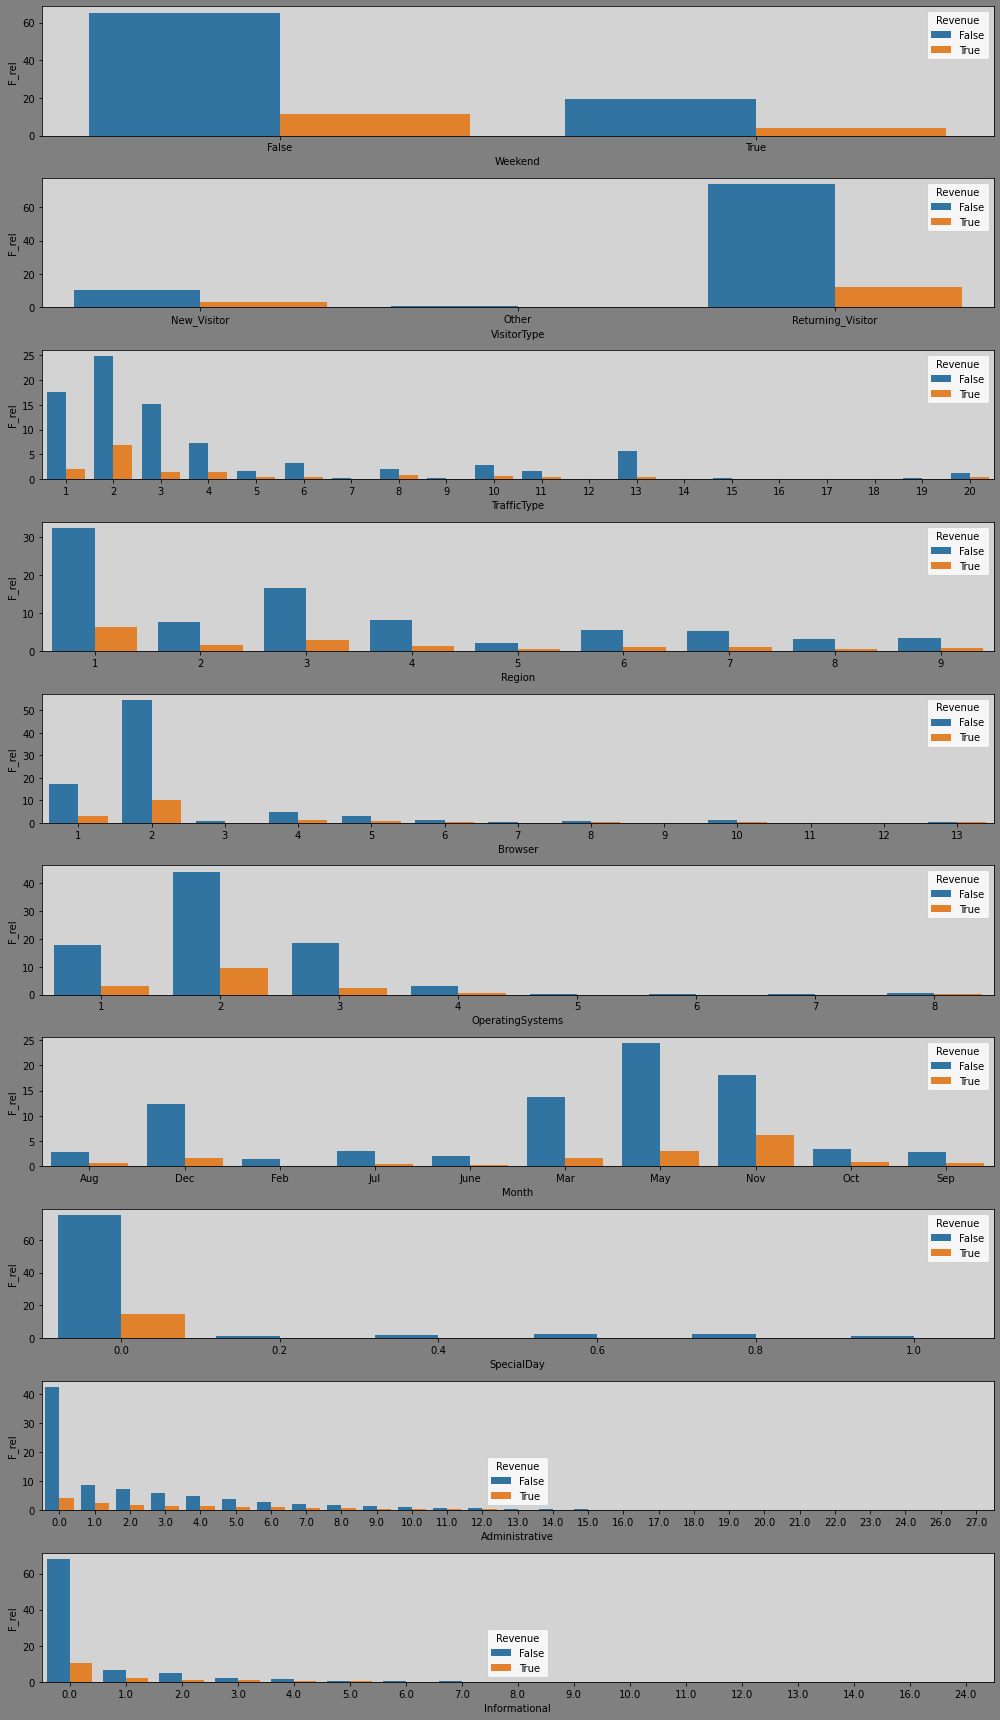

In [ ]:
bar_plot_groups(intentions_no_null, cat_cols[1:], "Revenue")

Información relevante de algunas *features*:
1. Month: no hay datos de los meses abril ni enero. Sería interesante crear una feature que informe de los trimestres. Habría que tener en cuenta que el ${1^{er}}$ y ${2^{do}}$ trimestre  infrarrepresentados, ya que carecen de datos de diciembre y abril, respectivamente.
1. Es posible que algunas variables no sean relevantes para negocio. Por ejemplo, podría resultar interesante saber qué buscadores (feature *Browser*) utilizan con más frecuencia los usuarios, pero es un factor poco relevante o difícil de controlar para ofrecer un mejor servicio. Esta feature podría ser eliminada para estudios posteriores.
1. El sistema operativo (feature *OperatingSystem*) está en una situación similar a *Browser*, por lo que también podría ser eliminada.
1. *TrafficType* podría referirse a las fuentes de tráfico desde donde provinen los clientes, la cual sería útil para encontrar cuáles son más atractivas para los usuarios y, así, priorizarlas.
1. *VisitorType* contiene un nivel *Other* que no especifica el tipo de usuario. Se podría optar por eliminar las filas que lo contienen por ser poco frecuente y no aportar información relevante del tipo de visitante.
1. *SpecialDay* 0 presenta una frecuencia relativa elevada cuando hay Revenue respecto del resto de posibles valores. Esto podría indicar que los usuarios realizan compras con cierta antelación ante un evento próximo, por ejemplo, 1 semana de antelación.
1. Las frecuencias en *Weekend* indican que los usuarios tienden a realizar más compras durante la semana. Dicha frecuencia solo es ligeramente superior a la del fin de semana. No obstante, la diferencia se explica por la mayor duración de la semana, es decir, 5 días frente a 2 del fin de semana.
1. Las feature *Administrative* y *Informational* no especifica una descripción relevante. Podríamos decir que la frecuencia de cada nivel, independientemente del Revenue, desciende progresivamente a medida que se asciende a niveles superiores (positivos). Se podría optar por eliminar ambas o agrupar los niveles actuales. Por ejemplo, los 5 primeros niveles de *Administrative* formarían un nivel nuevo. A pesar de dicho cambio, el aspecto de la distribución sería el mismo.

Visualizamos las distribuciones de las variables numéricas a través de *boxplots* e histogramas

In [ ]:
#multi_boxplot_hist(intentions_no_null[cols_for_ploting], "Revenue")

Boxplots

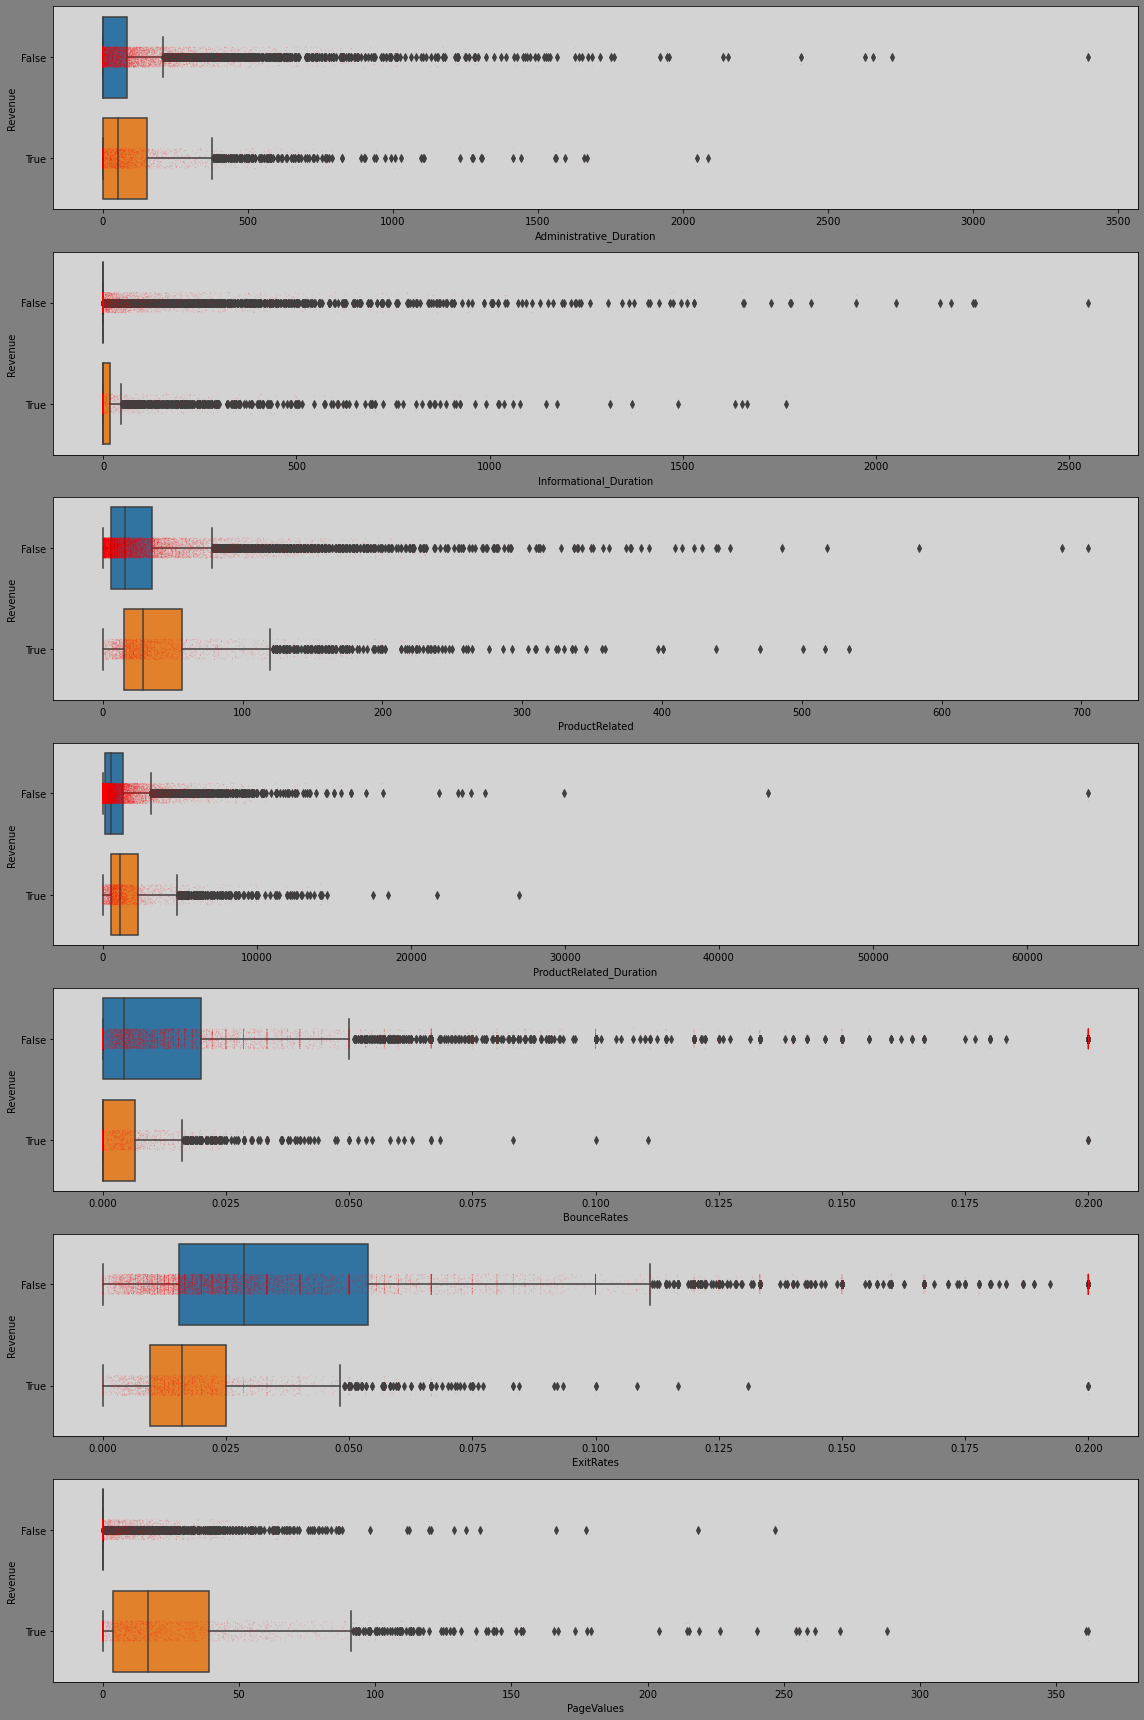

In [ ]:
cols_for_ploting = num_cols + ["Revenue"]
multi_plot_numerical(intentions_no_null[cols_for_ploting], "Revenue", "boxplot")

En general, existe un número elevado de outliers

Histograms

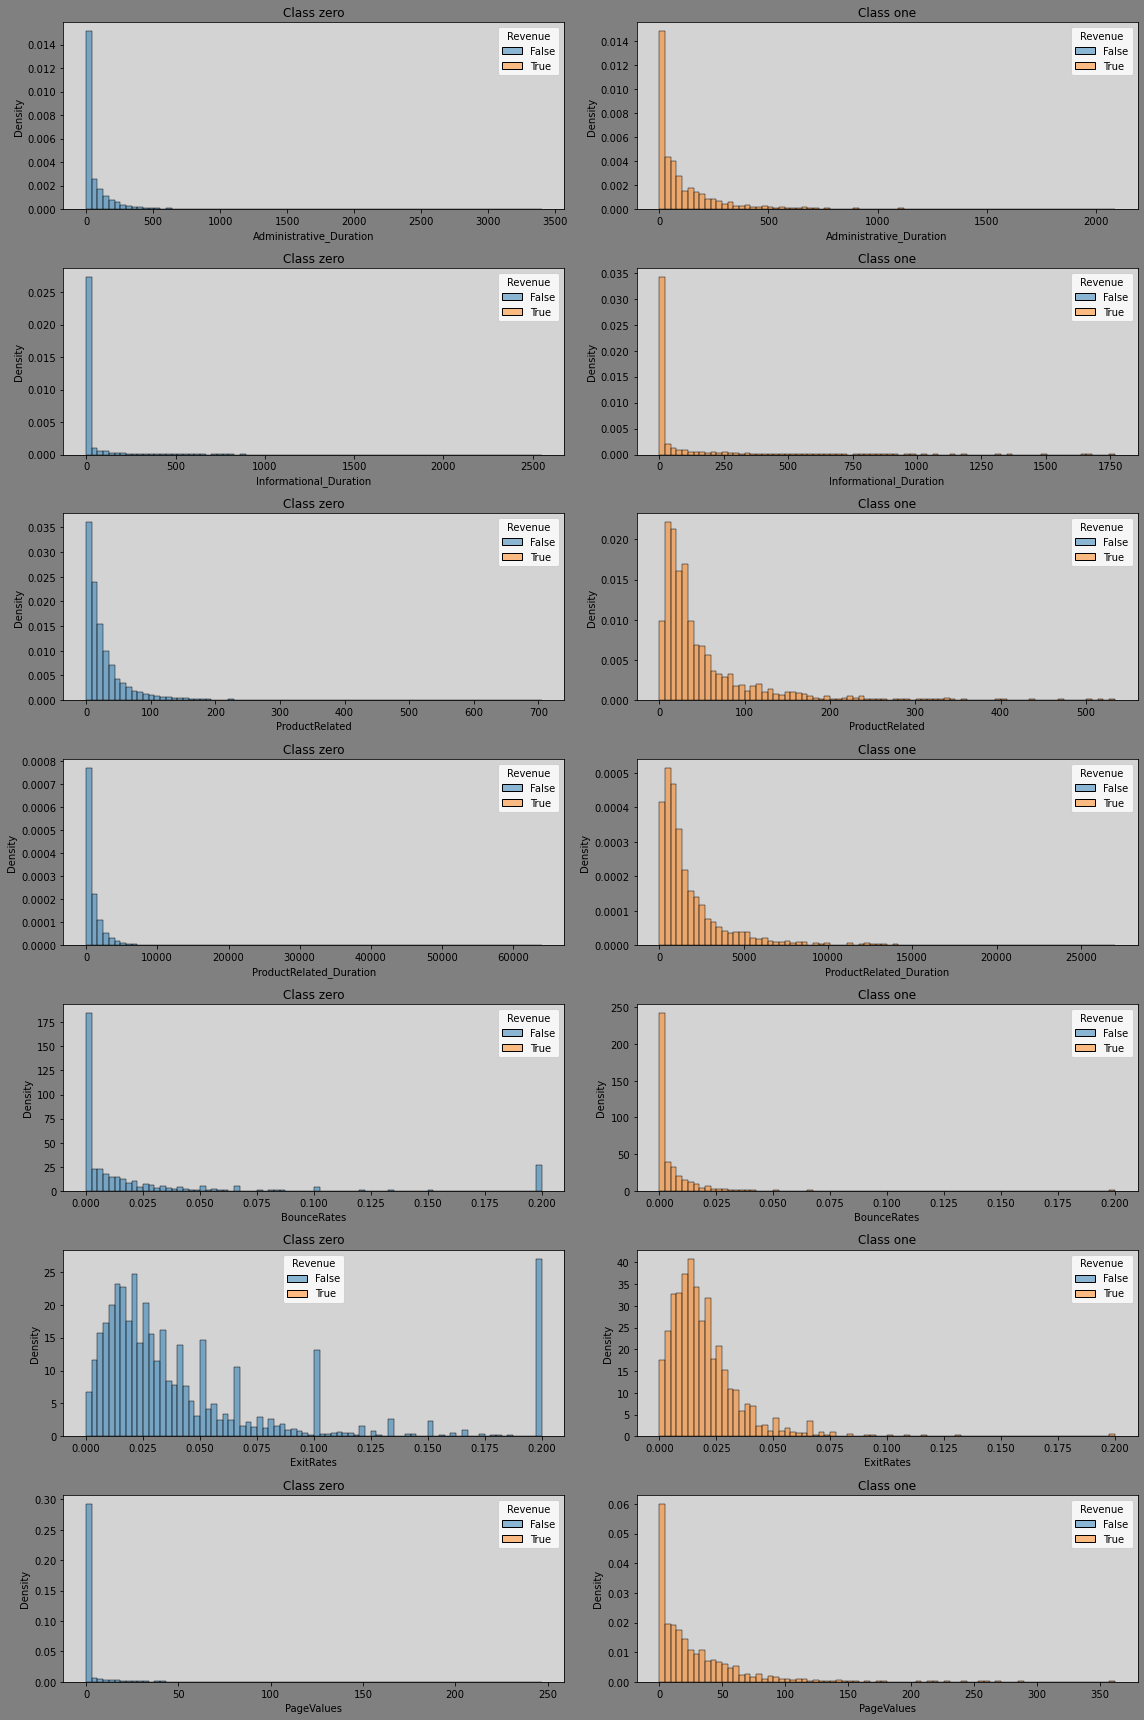

In [ ]:
multi_plot_numerical(intentions_no_null[cols_for_ploting], "Revenue", "hist", bins=80, stat="density")

Las features *Administrative_duration*, *Informational_duration*, *Bounce_rates* and *PageValues* presentan una densidad elevada en valores cercanos a zero.

El resto de features *ProductRelated* y *ProductRelated_duration* y *ExitRates* presentan una distribución con asimetría positiva, es decir, la cola de la distribución se extiende hacia valores positivos y reduce sustancialmente su densidad. *ProductRelated* y *ProductRelated_duration* presenta mayor densidad hacia valores ligeramente superiores a cero en la clase 1.

*PageValues* se concentra principalmente cerca de zero si la clase es zero. Lo mismo ocurre para la clase 1, pero también existe cierta densidad en valores superiores.

Podemos comprobar el aspecto de las distribuciones al suprimir el valor zero, ya que es muy abundante y podría estar ocultando aspectos interesantes dentro de la distribución.


In [ ]:
# Eliminar valores zero
intentions_no_null[cols_for_ploting].replace(0, np.nan).dropna().head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Revenue
262,158.000000,64.000000,29.0,1916.761905,0.006452,0.018710,8.772473,True
399,191.200000,654.333333,31.0,1204.600433,0.000855,0.013342,11.920096,True
424,74.000000,629.000000,149.0,5042.458059,0.003871,0.007285,18.368049,True
610,176.250000,404.000000,41.0,2720.671429,0.012963,0.033262,8.833826,True
612,523.214286,263.000000,48.0,2309.732468,0.003846,0.014904,10.600892,True


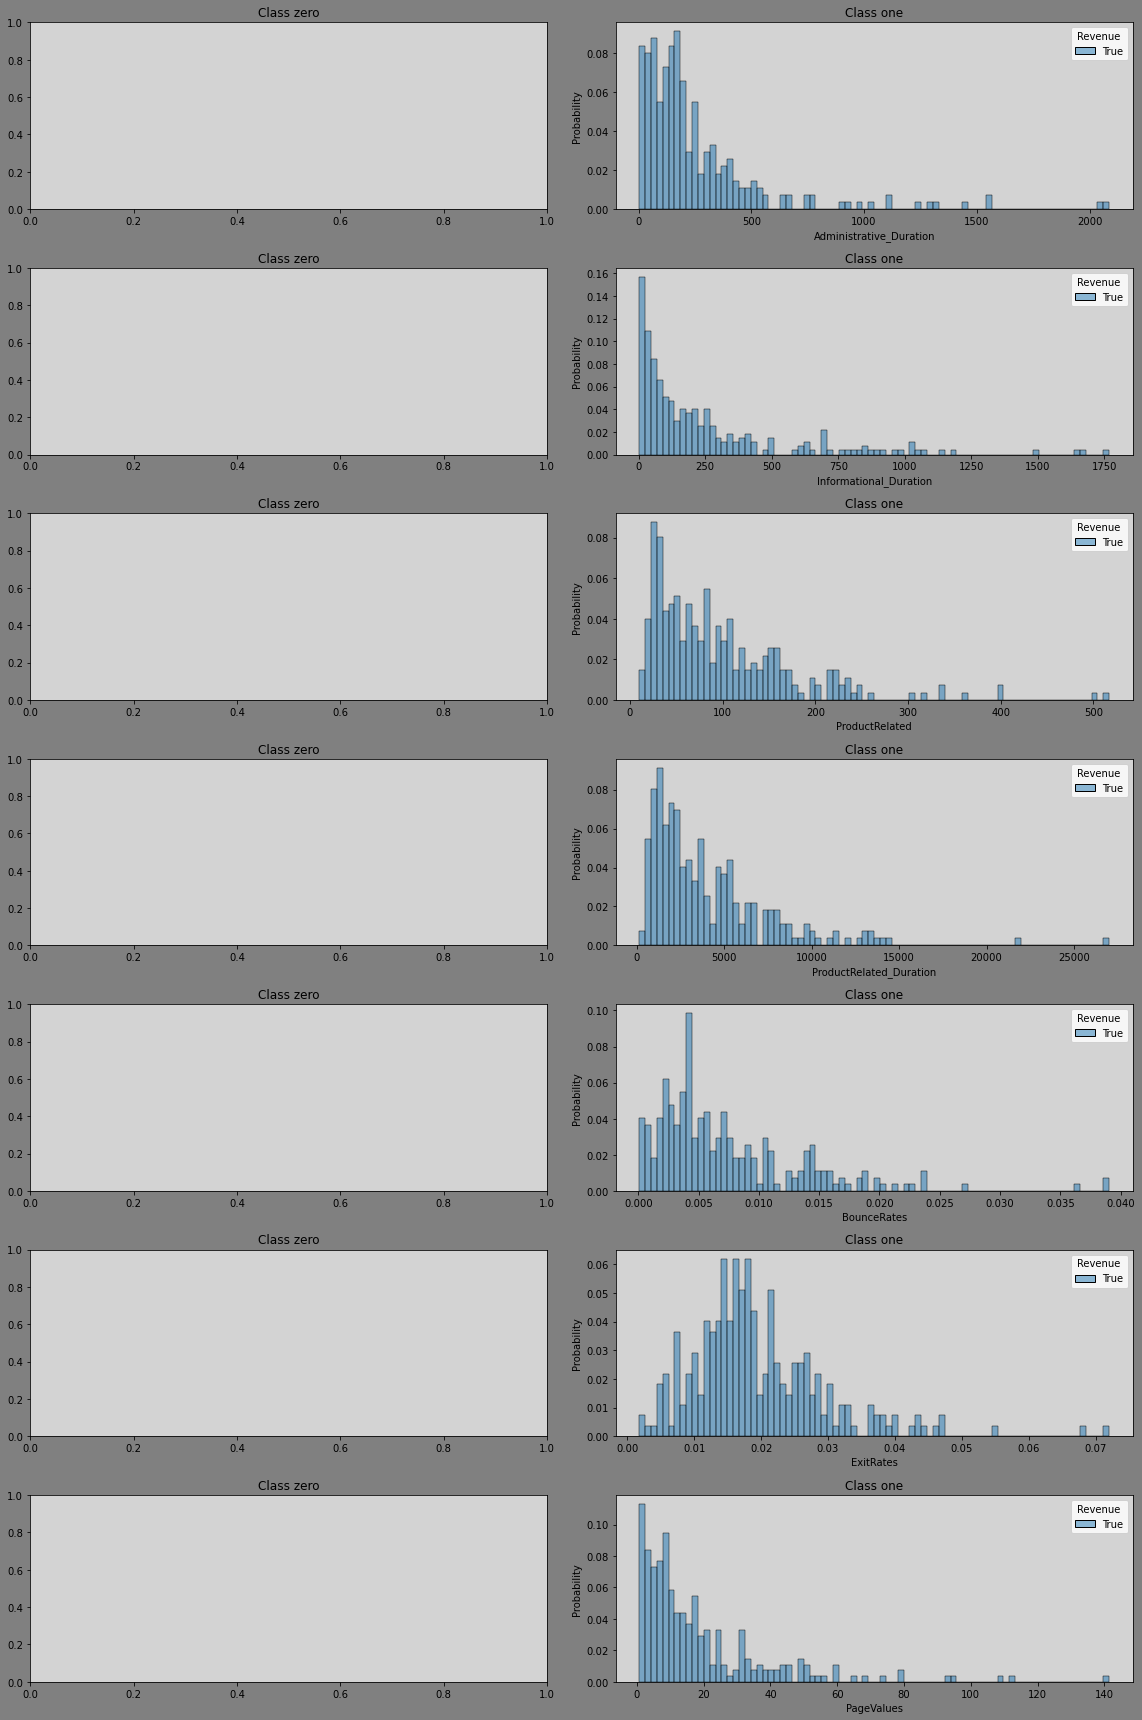

In [ ]:
multi_plot_numerical(intentions_no_null[cols_for_ploting].replace(0, np.nan).dropna(),
                     "Revenue",
                     "hist",
                     bins=80)

La principal observación que podemos obtener es el desplazamiento hacia la derecha del tope de la distribución de la feature BounceRate. Sin embargo, los datos son reducidos debido al filtro introducido y no se debería concluir que los clientes con más interacción se puedan representar con certeza a través de estas distribuciones.

### Agrupamientos de features

Vamos a grupar las features categóricas por pares y representaremos los grupos más relevantes según frecuencia

Agrupara pares de features

In [ ]:
group_pairs = pair_grouping(intentions_no_null[cat_cols])
len(group_pairs)

55

Extrae los pares más frecuentes

In [ ]:
group_pairs_relevant = extract_relevant_pairs(group_pairs)

In [ ]:
group_pairs_relevant[0]

,,F_abs,F_rel (%),F_rel_cum
Administrative,Informational,,,
0.0,0.0,5292,42.968496,42.968496
1.0,0.0,1052,8.541734,51.510231
2.0,0.0,848,6.885352,58.395583
3.0,0.0,675,5.480676,63.876259
4.0,0.0,543,4.408899,68.285158
5.0,0.0,373,3.028581,71.313738
6.0,0.0,257,2.086716,73.400455
0.0,1.0,230,1.867489,75.267944
7.0,0.0,192,1.558948,76.826892


In [ ]:
x = group_pairs_relevant[0].copy()
x.reset_index(inplace=True)
x["aux"] = group_pairs_relevant[0].reset_index().iloc[:, :2].astype(str).agg('-'.join, axis=1)

In [ ]:
x

,Administrative,Informational,F_abs,F_rel (%),F_rel_cum,aux
0,0.0,0.0,5292,42.968496,42.968496,0.0-0.0
1,1.0,0.0,1052,8.541734,51.510231,1.0-0.0
2,2.0,0.0,848,6.885352,58.395583,2.0-0.0
3,3.0,0.0,675,5.480676,63.876259,3.0-0.0
4,4.0,0.0,543,4.408899,68.285158,4.0-0.0
5,5.0,0.0,373,3.028581,71.313738,5.0-0.0
6,6.0,0.0,257,2.086716,73.400455,6.0-0.0
7,0.0,1.0,230,1.867489,75.267944,0.0-1.0
8,7.0,0.0,192,1.558948,76.826892,7.0-0.0
9,1.0,1.0,150,1.217928,78.044820,1.0-1.0


In [ ]:
group_pairs_relevant

[                              F_abs  F_rel (%)  F_rel_cum
 Administrative Informational                             
 0.0            0.0             5292  42.968496  42.968496
 1.0            0.0             1052   8.541734  51.510231
 2.0            0.0              848   6.885352  58.395583
 3.0            0.0              675   5.480676  63.876259
 4.0            0.0              543   4.408899  68.285158
 5.0            0.0              373   3.028581  71.313738
 6.0            0.0              257   2.086716  73.400455
 0.0            1.0              230   1.867489  75.267944
 7.0            0.0              192   1.558948  76.826892
 1.0            1.0              150   1.217928  78.044820,
                           F_abs  F_rel (%)  F_rel_cum
 SpecialDay Informational                             
 0.0        0.0             8624  70.022735  70.022735
            1.0              945   7.672946  77.695680
            2.0              677   5.496915  83.192595
            3.0 

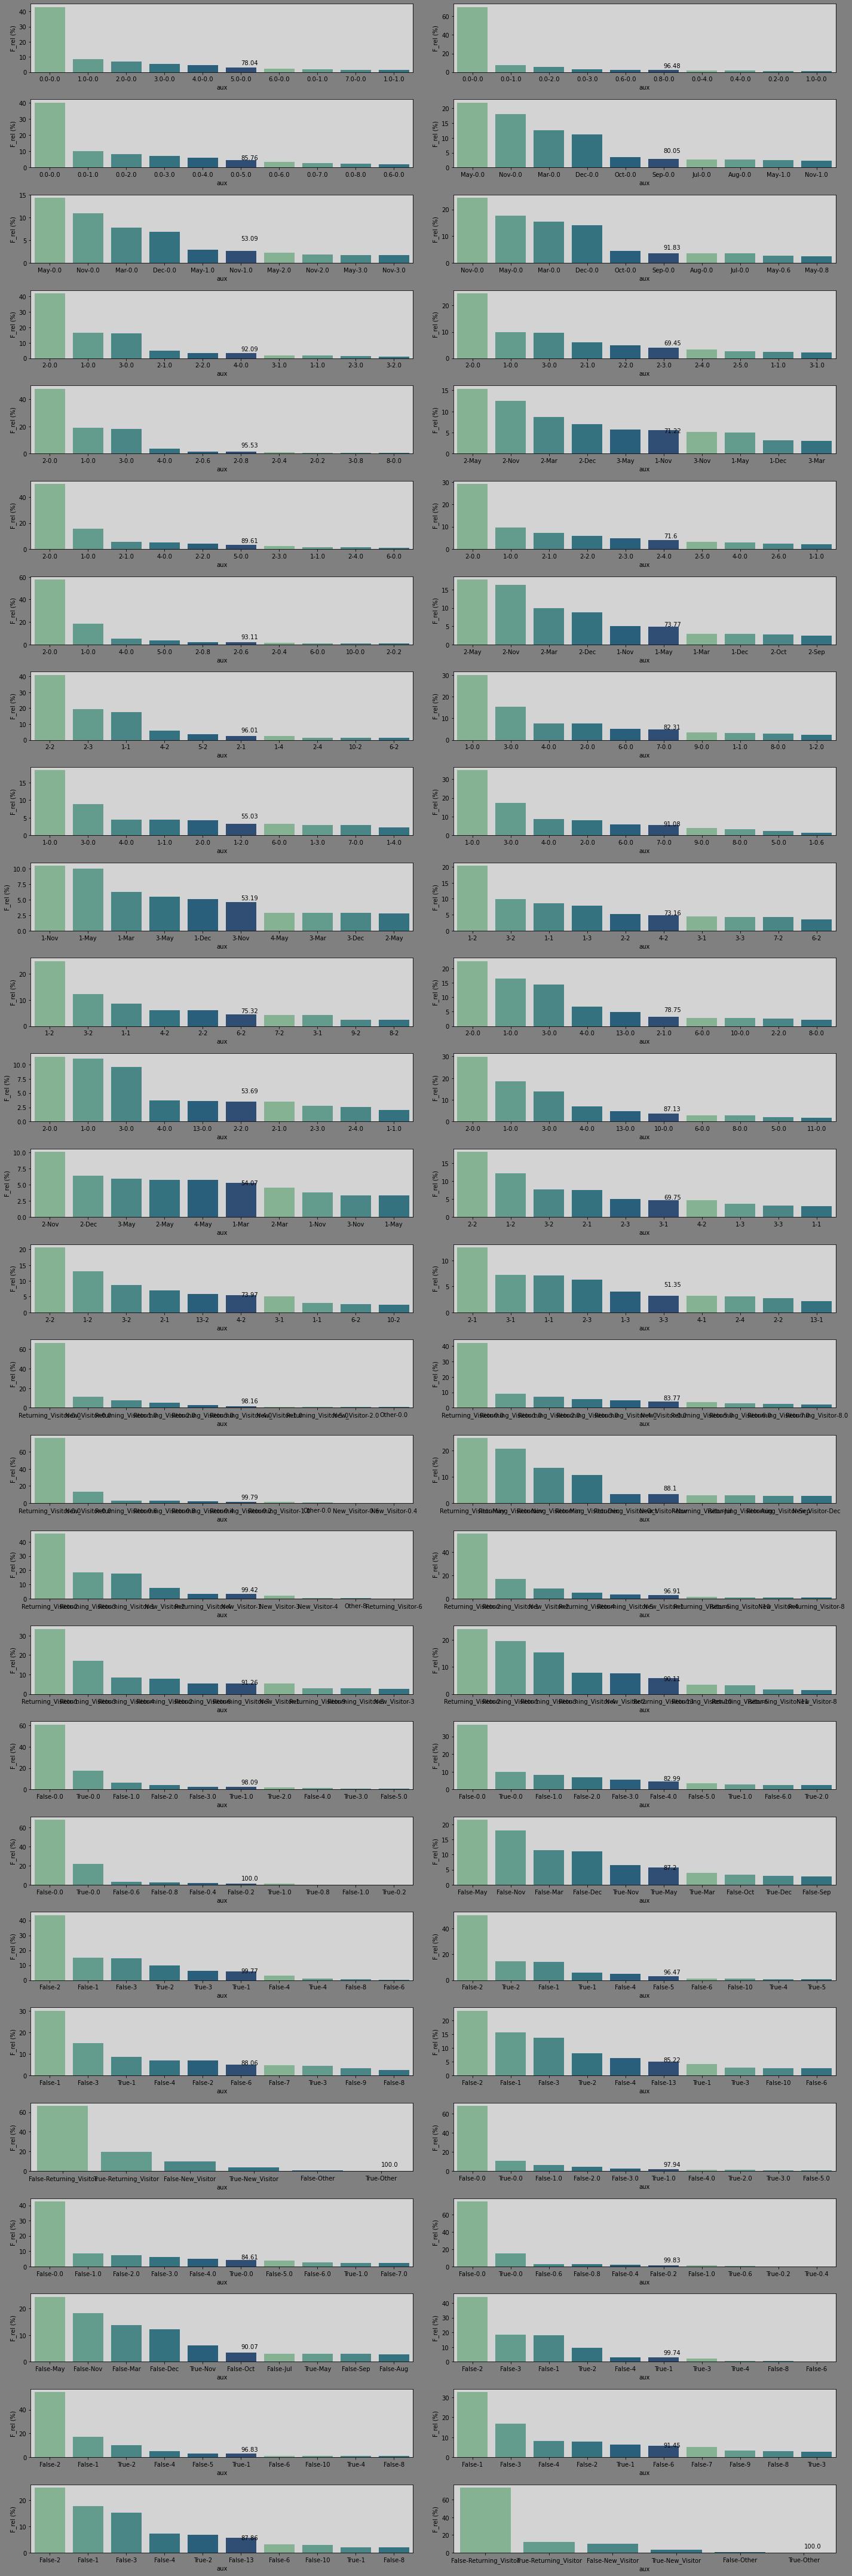

In [ ]:
bar_plot_group_list(group_pairs_relevant)

In [ ]:
import altair as alt
from vega_datasets import data

In [ ]:
cars = data.cars()
cars.head()

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA


In [ ]:
cars = pd.melt(data.cars(), ['Miles_per_Gallon', 'Origin', 'Name', 'Year'], value_name='feature')
cars

,Miles_per_Gallon,Origin,Name,Year,variable,feature
0,18.0,USA,chevrolet chevelle malibu,1970-01-01,Cylinders,8.0
1,15.0,USA,buick skylark 320,1970-01-01,Cylinders,8.0
2,18.0,USA,plymouth satellite,1970-01-01,Cylinders,8.0
3,16.0,USA,amc rebel sst,1970-01-01,Cylinders,8.0
4,17.0,USA,ford torino,1970-01-01,Cylinders,8.0
...,...,...,...,...,...,...
2025,27.0,USA,ford mustang gl,1982-01-01,Acceleration,15.6
2026,44.0,Europe,vw pickup,1982-01-01,Acceleration,24.6
2027,32.0,USA,dodge rampage,1982-01-01,Acceleration,11.6
2028,28.0,USA,ford ranger,1982-01-01,Acceleration,18.6


In [ ]:
cars['variable'].unique().tolist()

['Cylinders', 'Displacement', 'Horsepower', 'Weight_in_lbs', 'Acceleration']

In [ ]:
select_box = alt.binding_select(options=cars['variable'].unique().tolist())
selection = alt.selection_single(name='x_axis', fields=['variable '], bind=select_box)

alt.Chart(cars).mark_point().encode(
    y='Miles_per_Gallon:Q',
    x='feature',
    color='Origin',
    tooltip='Name'
).add_selection(
    selection
).transform_filter(
    selection
)

alt.Chart(...)

In [ ]:
from copy import deepcopy

In [ ]:
def melt_frequencies(df_list):
    my_list = []
    temp = deepcopy(df_list)
    for df in temp:
        df.reset_index(inplace=True)
        columns_to_join = [df.columns[0], df.columns[1]]
        new_column = '_'.join(columns_to_join)
        x = df[[columns_to_join[0], columns_to_join[1], "F_rel (%)"]]
        x.loc[:, new_column] = x.loc[:, columns_to_join].astype(str).agg('-'.join, axis=1)
        x.drop(columns_to_join, axis=1, inplace=True)
        x = pd.melt(x, ['F_rel (%)'], var_name="group", value_name='group-pair') #value_name='values_' + new_column
        my_list.append(x)
    return pd.concat(my_list, axis=0)

In [ ]:
melted_frequencies = melt_frequencies(group_pairs_relevant)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [ ]:
melted_frequencies

,F_rel (%),group,group-pair
0,42.968496,Administrative_Informational,0.0-0.0
1,8.541734,Administrative_Informational,1.0-0.0
2,6.885352,Administrative_Informational,2.0-0.0
3,5.480676,Administrative_Informational,3.0-0.0
4,4.408899,Administrative_Informational,4.0-0.0
...,...,...,...
5,0.129912,Revenue_VisitorType,True-Other
0,65.297174,Revenue_Weekend,False-False
1,19.210783,Revenue_Weekend,False-True
2,11.440403,Revenue_Weekend,True-False


In [ ]:
select_box = alt.binding_select(options=melted_frequencies['group'].unique().tolist())
selection = alt.selection_single(name='x_axis', fields=['group'], bind=select_box)

alt.Chart(melted_frequencies).mark_bar().encode(
    y='F_rel (%):Q',
    x='group-pair'
).add_selection(
    selection
).transform_filter(
    selection
)

alt.Chart(...)

## 3) Tratamiento de categóricas, pasándolas a numéricas por medio de dummies, mapeándolas o utilizando un label encoder. Hay que justificar las operaciones que se realizan.

In [ ]:
pd.get_dummies(intentions_no_null[cat_cols], drop_first=True, dtype=int)

,Revenue_True,Weekend_True,VisitorType_Other,VisitorType_Returning_Visitor,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,...,OperatingSystems_8,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
12326,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12327,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12328,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
extended_describe(intentions_no_null)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.895952,0.061497
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.577926,0.199020
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000
cv,1.433582,2.185994,2.521340,4.081142,1.400658,1.600596,2.186083,1.128475,3.150963,3.236235
unbiased_cv,3.322821,176.864018,1.270727,140.828335,44.491241,1914.411326,0.048428,0.048528,18.578302,0.199024
qcd,1.000000,1.000000,NaN,NaN,0.688889,0.775959,1.000000,0.555556,NaN,NaN


In [ ]:
matriz_correlaciones = intentions_no_null.corr(method='pearson') * np.logical_not(np.eye(10)).astype("int8")

In [ ]:
matriz_correlaciones

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
Administrative,0.000000,0.601466,0.376782,0.255757,0.430832,0.373647,-0.223474,-0.316192,0.098771,-0.095054
Administrative_Duration,0.601466,0.000000,0.302647,0.237959,0.288869,0.355238,-0.144128,-0.205618,0.067463,-0.073472
Informational,0.376782,0.302647,0.000000,0.618965,0.374098,0.387446,-0.116071,-0.163539,0.048539,-0.048328
Informational_Duration,0.255757,0.237959,0.618965,0.000000,0.279966,0.347300,-0.074077,-0.105205,0.030787,-0.030658
ProductRelated,0.430832,0.288869,0.374098,0.279966,0.000000,0.860868,-0.204469,-0.292219,0.056067,-0.024190
ProductRelated_Duration,0.373647,0.355238,0.387446,0.347300,0.860868,0.000000,-0.184409,-0.251645,0.052623,-0.036598
BounceRates,-0.223474,-0.144128,-0.116071,-0.074077,-0.204469,-0.184409,0.000000,0.913436,-0.119357,0.073088
ExitRates,-0.316192,-0.205618,-0.163539,-0.105205,-0.292219,-0.251645,0.913436,0.000000,-0.174397,0.102899
PageValues,0.098771,0.067463,0.048539,0.030787,0.056067,0.052623,-0.119357,-0.174397,0.000000,-0.063660
SpecialDay,-0.095054,-0.073472,-0.048328,-0.030658,-0.024190,-0.036598,0.073088,0.102899,-0.063660,0.000000


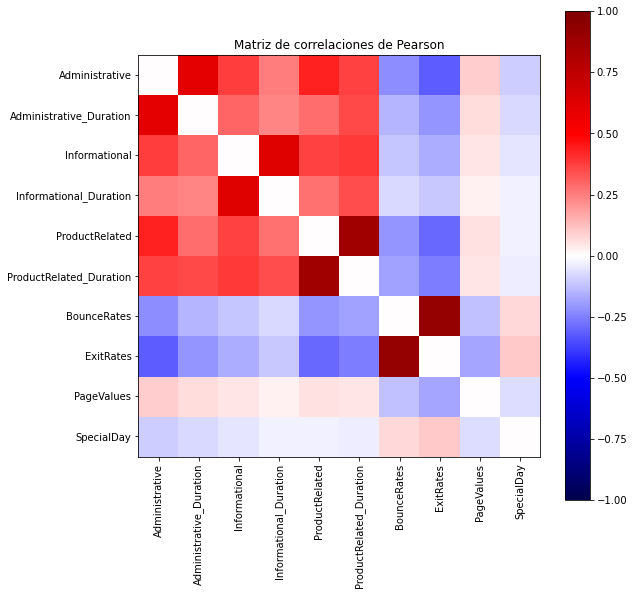

In [ ]:
n_ticks = len(intentions_orig.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), intentions_orig.columns, rotation='vertical')
plt.yticks(range(n_ticks), intentions_orig.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest',
                            vmin=-1., vmax=1.,
                            cmap=plt.get_cmap('seismic'))) # Blues seismic bwr
_ = plt.title('Matriz de correlaciones de Pearson')

## 3) Transformación de los datos para cumplir las hipótesis:

In [ ]:
clients_numerical = intentions_orig[intentions_orig.columns[2:]].copy()
clients_numerical_trans = clients_numerical.copy()

In [ ]:
clients_numerical.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


box-cox transformation

In [ ]:
for col in clients_numerical_trans.columns:
    clients_numerical_trans[col] = stats.boxcox(clients_numerical_trans[col])[0]
clients_numerical_trans.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,51.736919,12.670296,16.694342,6.887991,10.154313,15.470232
1,42.989031,12.699553,17.444169,10.638490,10.494584,16.620941
2,41.571828,12.500943,16.745021,11.254315,10.602565,23.790243
3,52.490385,9.068054,14.932092,13.308825,7.587652,16.649068
4,62.025081,11.620137,16.540472,12.253988,9.499037,21.583731


In [ ]:
extended_des = extended_describe(clients_numerical_trans)
extended_des

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,44.845742,10.856013,15.434100,10.443894,8.555818,14.007201
std,16.718993,1.854735,3.210891,2.443837,2.592704,4.362090
min,1.297776,4.596233,1.179625,3.730425,1.136529,1.222366
25%,33.082657,9.470306,13.054012,9.014500,6.610681,11.270068
50%,45.615090,10.918724,15.281914,10.359550,8.296571,14.219307
75%,56.668564,12.130722,17.794722,12.052169,10.783593,16.723910
max,101.573143,16.688053,25.969330,18.774933,14.972315,35.778584
cv,0.372811,0.170849,0.208039,0.233997,0.303034,0.311418
unbiased_cv,16.728493,1.855788,3.212716,2.445226,2.594177,4.364568
qcd,0.262792,0.123162,0.153676,0.144193,0.239901,0.194822


Validate Function

In [ ]:
# Outliers per column
detect_outliers_IQR_df(clients_numerical_trans).sum()

Fresh                1
Milk                 2
Grocery              2
Frozen               8
Detergents_Paper     0
Delicassen          11
dtype: int64

In [ ]:
# Specific outliers
outliers = detect_outliers_IQR_df(clients_numerical_trans)
for col in clients_numerical_trans.columns:
    filters = outliers[col].astype("bool")
    print(clients_numerical_trans.loc[filters, col], "\n")

181    101.573143
Name: Fresh, dtype: float64 

86     16.688053
154     4.596233
Name: Milk, dtype: float64 

75     1.179625
85    25.969330
Name: Grocery, dtype: float64 

38      4.105383
57      4.299517
65      4.224827
93     17.328537
145     4.438733
183    17.437506
325    18.774933
420     3.730425
Name: Frozen, dtype: float64 

Series([], Name: Detergents_Paper, dtype: float64) 

23     28.228416
71     27.391986
87     27.339709
109     1.222366
128     1.222366
142     1.222366
154     2.552898
183    35.778584
184     3.041318
187     1.222366
233     2.356774
Name: Delicassen, dtype: float64 



Corrected dataframe

In [ ]:
clients_numerical_trans_corrected = correct_outliers_to_IQR(clients_numerical_trans)
clients_numerical_trans_corrected

Fresh 92.04742418121143 -2.2962031126927798 23.58590682347605
Milk 16.121344305687362 5.479683663133844 2.6604151606383795
Grocery 24.90578737700629 5.942947369141335 4.740710001966239
Frozen 16.60867293600144 4.457996780533938 3.0376690388668752
Detergents_Paper 17.042960925842717 0.35131279660186276 4.172912032310213
Delicassen 24.90467280410747 3.089305391986576 5.453841853030223


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,51.736919,12.670296,16.694342,6.887991,10.154313,15.470232
1,42.989031,12.699553,17.444169,10.638490,10.494584,16.620941
2,41.571828,12.500943,16.745021,11.254315,10.602565,23.790243
3,52.490385,9.068054,14.932092,13.308825,7.587652,16.649068
4,62.025081,11.620137,16.540472,12.253988,9.499037,21.583731
...,...,...,...,...,...,...
435,67.509485,13.082824,19.168372,14.934483,6.131939,17.541051
436,73.578823,9.358068,10.462168,12.552512,5.226444,17.814282
437,54.015018,13.557444,21.453263,8.079721,13.088843,16.830525
438,48.453003,9.892812,13.150498,9.629617,6.022019,17.382819


In [ ]:
clients_numerical_trans_corrected.iloc[75]

Fresh               60.062043
Milk                 8.986896
Grocery              5.942947
Frozen              12.503507
Detergents_Paper     1.136529
Delicassen          14.255725
Name: 75, dtype: float64

Dummy variables

In [ ]:
channel_dict = {1: "horeca", 2: "minorista"}
region_dict = {1: "Lisbon", 2: "Oporto", 3: "Otros"}

In [ ]:
clients_dummies = pd.get_dummies(intentions_orig[["Channel", "Region"]], drop_first=True)
clients_dummies

,Channel_2,Region_2,Region_3
0,1,0,1
1,1,0,1
2,1,0,1
3,0,0,1
4,1,0,1
...,...,...,...
435,0,0,1
436,0,0,1
437,1,0,1
438,0,0,1


Scale the data with Min max method

In [ ]:
miMa_scaler = MinMaxScaler()

In [ ]:
X = clients_numerical_trans_corrected.values.copy()

In [ ]:
miMa_scaler.fit(X)

MinMaxScaler()

In [ ]:
X_scaled = miMa_scaler.transform(X)

## 4) Aplicación del método del codo sobre los datos escalados ajustando K-means. Obtención del valor óptimo de k.

Utilizando el valor óptimo k anterior, ajustar el modelo.

In [ ]:
# Try 18 clusters
clusters = np.arange(2, 20 + 1)
inertias = []

for cluster in clusters:
    clusterer = KMeans(n_clusters=cluster, n_init=20, random_state=117)
    clusterer.fit(X)
    inertias.append(clusterer.inertia_)
    print("Number of clusters: ", cluster)
    print("Inertia: ", clusterer.inertia_)
    print("number of iterations: ", clusterer.n_iter_)
    print("")

Number of clusters:  2
Inertia:  62048.92250663116
number of iterations:  3

Number of clusters:  3
Inertia:  40017.022916412905
number of iterations:  17

Number of clusters:  4
Inertia:  31103.14120578345
number of iterations:  6

Number of clusters:  5
Inertia:  26192.168352310113
number of iterations:  7

Number of clusters:  6
Inertia:  23766.527419753384
number of iterations:  25

Number of clusters:  7
Inertia:  21753.127613229313
number of iterations:  20

Number of clusters:  8
Inertia:  20305.88804239489
number of iterations:  21

Number of clusters:  9
Inertia:  18801.261578225425
number of iterations:  20

Number of clusters:  10
Inertia:  17850.98984509008
number of iterations:  17

Number of clusters:  11
Inertia:  16849.78152311133
number of iterations:  11

Number of clusters:  12
Inertia:  16085.448831619005
number of iterations:  13

Number of clusters:  13
Inertia:  15154.084080997394
number of iterations:  13

Number of clusters:  14
Inertia:  14670.686222424974
num

In [ ]:
serie_iner= pd.Series(inertias)
serie_iner

0     62048.922507
1     40017.022916
2     31103.141206
3     26192.168352
4     23766.527420
5     21753.127613
6     20305.888042
7     18801.261578
8     17850.989845
9     16849.781523
10    16085.448832
11    15154.084081
12    14670.686222
13    14003.158514
14    13352.078275
15    12864.029844
16    12598.516944
17    12171.332557
18    11746.395099
dtype: float64

In [ ]:
# Differences between i and i + 1 (i.e. numeric improvement from i to i + 1)
pd.concat((serie_iner, 100 * serie_iner.diff(-1).div(serie_iner).round(4), pd.Series(clusters)), axis=1)

,0,1,2
0,62048.922507,35.51,2
1,40017.022916,22.28,3
2,31103.141206,15.79,4
3,26192.168352,9.26,5
4,23766.527420,8.47,6
5,21753.127613,6.65,7
6,20305.888042,7.41,8
7,18801.261578,5.05,9
8,17850.989845,5.61,10
9,16849.781523,4.54,11


We can see that inertia does not improve notably from 8 - 9 clusters on. Lets take cluster 9

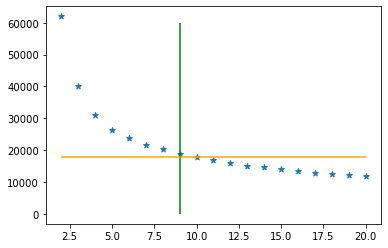

In [ ]:
plt.scatter(clusters, inertias, marker='*')
plt.vlines(9, 0, 60000, color="green")
plt.hlines(18000, 2, 20, color="orange")

In [ ]:
clusterer_opt = KMeans(n_clusters=9, n_init=20, random_state=117).fit(X)
print("Inertia:", clusterer_opt.inertia_)

Inertia: 18801.261578225425


## 5) Realización de una transformación PCA con dos componentes de los datos escalados. Representación del PCA. ¿Se separan bien los datos en grupos?

In [ ]:
pca = PCA(n_components=2, random_state=117)

In [ ]:
X_pca_2_comp = pca.fit_transform(X)

Train a cluster model

In [ ]:
clusterer_opt_pca_2_comp = KMeans(n_clusters=9, n_init=20, random_state=117).fit(X_pca_2_comp)

Let's represent both components in a scatter plot

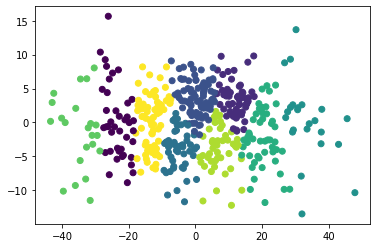

In [ ]:
plt.scatter(X_pca_2_comp[:, 0], X_pca_2_comp[:, 1], c=clusterer_opt_pca_2_comp.labels_)

In [ ]:
print("Inertia:", clusterer_opt_pca_2_comp.inertia_)

Inertia: 10992.503166081442


We see that the data points are arranged in vertical strip patterns. The inertia value (or Sum of squared distances of samples to their closest cluster center) is lower than that inertia value acquired for the full dataset

## 6) Obtención de la media de las variables originales para cada uno de los grupos en los que se divide el dataset al utilizar el K-means con k óptimo.

In [ ]:
point_to_cluster = clusterer_opt.labels_
point_to_cluster.shape

(440,)

In [ ]:
clients_numerical_with_clusters = clients_numerical.copy()
clients_numerical_with_clusters["cluster"] = point_to_cluster
clients_numerical_with_clusters.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,12669,9656,7561,214,2674,1338,5
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,0
3,13265,1196,4221,6404,507,1788,5
4,22615,5410,7198,3915,1777,5185,8


In order to calculate the mean value for each feature in every cluster, we should group the data by the new cluster feature.

In [ ]:
clients_numerical_with_clusters.value_counts("cluster").sort_values()

cluster
7    20
4    23
2    43
0    48
8    49
5    49
1    57
3    69
6    82
dtype: int64

In [ ]:
clients_numerical_with_clusters.groupby("cluster").mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0,5771.520833,10081.583333,14240.729167,2243.312500,6602.000000,1822.083333
1,17237.333333,2034.035088,2819.052632,3251.526316,570.982456,837.263158
2,894.720930,6516.813953,9337.069767,1076.860465,3512.093023,973.302326
3,2875.072464,4558.739130,6775.072464,2055.550725,2692.159420,1113.797101
4,49806.913043,6613.130435,7414.000000,5977.652174,1957.869565,2580.913043
5,13070.857143,8789.693878,12691.346939,3333.346939,4761.469388,2383.183673
6,8394.036585,2173.536585,2932.134146,3026.756098,771.036585,593.109756
7,146.100000,6946.250000,13921.600000,1188.900000,5708.750000,1118.450000
8,26662.306122,9301.489796,9675.142857,6075.591837,2569.244898,3467.632653


In [ ]:
extended_describe(clients_numerical_with_clusters).loc["mean", :]

Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicassen           1524.870455
cluster                 3.888636
Name: mean, dtype: float64